In [13]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('../2.linear_regression_models/AB_NYC_2019.csv')

In [4]:
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [3]:
features = [
    'neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'price'
]

In [5]:
df = df[features]

In [6]:
df.head(3)

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,Brooklyn,Private room,40.64749,-73.97237,1,9,0.21,6,365,149
1,Manhattan,Entire home/apt,40.75362,-73.98377,1,45,0.38,2,355,225
2,Manhattan,Private room,40.80902,-73.94190,3,0,NaN,1,365,150


In [7]:
df.isnull().sum()

neighbourhood_group                   0
room_type                             0
latitude                              0
longitude                             0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
price                                 0
dtype: int64

In [9]:
df.reviews_per_month = df.reviews_per_month.fillna(0)

In [11]:
df.isnull().sum().sum()

0

<AxesSubplot:xlabel='price', ylabel='Count'>

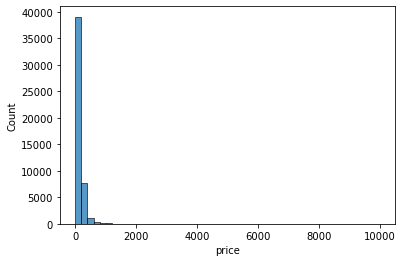

In [14]:
sns.histplot(df.price, bins=50)

In [ ]:
df.price = np.log1p(df.price)

<AxesSubplot:xlabel='price', ylabel='Count'>

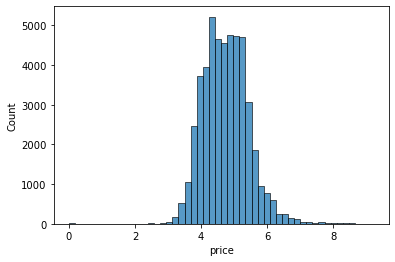

In [17]:
sns.histplot(df.price, bins=50)

In [18]:
from sklearn.model_selection import train_test_split

In [20]:
full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_valid = train_test_split(full_train, test_size=0.25, random_state=1)

In [22]:
y_full_train = full_train.price.values
y_test = df_test.price.values
y_train = df_train.price.values
y_valid = df_valid.price.values

In [23]:
del full_train['price']
del df_test['price']
del df_valid['price']
del df_train['price']

In [21]:
from sklearn.feature_extraction import DictVectorizer

In [24]:
dv = DictVectorizer(sparse=False)

In [26]:
dict_full = full_train.to_dict(orient='records')
dict_test = df_test.to_dict(orient='records')
dict_train = df_train.to_dict(orient='records')
dict_valid = df_valid.to_dict(orient='records')

In [58]:
X_train = dv.fit_transform(dict_train)
X_valid = dv.transform(dict_valid)

# Q1

In [59]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [60]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_dict, y_train)

DecisionTreeRegressor(max_depth=1)

In [61]:
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood_group=Bronx',
 'neighbourhood_group=Brooklyn',
 'neighbourhood_group=Manhattan',
 'neighbourhood_group=Queens',
 'neighbourhood_group=Staten Island',
 'number_of_reviews',
 'reviews_per_month',
 'room_type=Entire home/apt',
 'room_type=Private room',
 'room_type=Shared room']

In [62]:
from sklearn.tree import export_text

In [63]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



# Q2

In [64]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,
                                  n_jobs=-1)

In [66]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

def metrics(y_test, y_pred, X_train):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    n = y_pred.shape[0]
    k = X_train.shape[1]
    
    adjusted = 1 - (1 - r2) * (n - 1) / (n - 1 - k)
    return rmse, r2, adjusted

In [72]:
y_pred = rf.predict(X_valid)

In [73]:
rmse, r2, r2_adj = metrics(y_valid, y_pred, X_valid)

In [74]:
print(f"rmse: {rmse}; r2: {r2}; r2_adj: {r2_adj}")

rmse: 0.4615632303514057; r2: 0.5683444797218546; r2_adj: 0.5676812785742389


In [75]:
scores = {}

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,
                                  n_jobs=-1)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_valid)
    rmse, r2, r2_adj = metrics(y_valid, y_pred, X_valid)
    
    scores[n] = (rmse, r2, r2_adj)

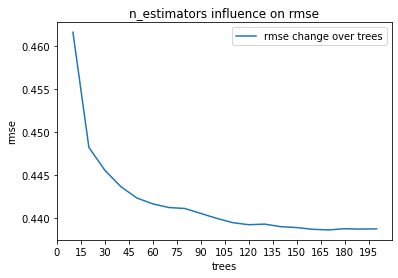

In [88]:
plt.plot(list(scores.keys()),
         list(map(lambda x: x[0], list(scores.values()))),
         label='rmse change over trees')

plt.title('n_estimators influence on rmse')
plt.xlabel('trees')
plt.ylabel('rmse')

plt.xticks(range(0, 201, 15))

plt.legend()
plt.show()

# Q4

In [115]:
def calc_rf(X_train, y_train, X_valid, y_valid):
    scores = {}
    
    for d in [10, 15, 20, 25]:
    
        score = []
        
        for n in range(10, 201, 10):
            rf = RandomForestRegressor(
                n_estimators=n, max_depth=d,
                n_jobs=-1, random_state=1
            )

            rf.fit(X_train, y_train)

            y_pred = rf.predict(X_valid)
            rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
            
            score.append(rmse)

        scores[d] = score
    
    return scores

In [116]:
result = calc_rf(X_train, y_train, X_valid, y_valid)

In [120]:
trees = list(range(10, 201, 10))

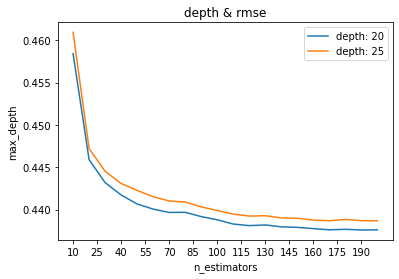

In [126]:
plt.plot(trees, result[20], label='depth: 20')
plt.plot(trees, result[25], label='depth: 25')

plt.xticks(range(10, 201, 15))
plt.title('depth & rmse')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

plt.legend()
plt.show()

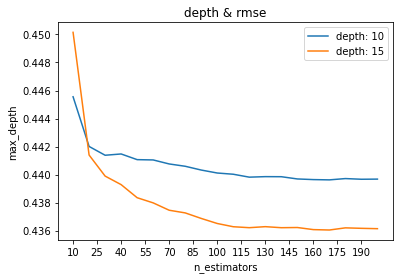

In [125]:
plt.plot(trees, result[10], label='depth: 10')
plt.plot(trees, result[15], label='depth: 15')

plt.xticks(range(10, 201, 15))
plt.title('depth & rmse')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')

plt.legend()
plt.show()

# Q5